# Documentation & Imports

In [1]:
"""
Dedalus script simulating the viscous shallow water equations on a sphere. This
script demonstrates solving an initial value problem on the sphere. It can be
ran serially or in parallel, and uses the built-in analysis framework to save
data snapshots to HDF5 files. The `plot_sphere.py` script can be used to produce
plots from the saved data. The simulation should about 5 cpu-minutes to run.

The script implements the test case of a barotropically unstable mid-latitude
jet from Galewsky et al. 2004 (https://doi.org/10.3402/tellusa.v56i5.14436).
The initial height field balanced the imposed jet is solved with an LBVP.
A perturbation is then added and the solution is evolved as an IVP.

To run and plot using e.g. 4 processes:
    $ mpiexec -n 4 python3 shallow_water.py
    $ mpiexec -n 4 python3 plot_sphere.py snapshots/*.h5
"""

import numpy as np
import dedalus.public as d3
import logging
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
logger = logging.getLogger(__name__)

2024-03-12 16:24:16,416 dedalus 0/1 WARNING :: Threading has not been disabled. This may massively degrade Dedalus performance.
2024-03-12 16:24:16,419 dedalus 0/1 WARNING :: We strongly suggest setting the "OMP_NUM_THREADS" environment variable to "1".
2024-03-12 16:24:17,685 numexpr.utils 0/1 INFO :: Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-03-12 16:24:17,686 numexpr.utils 0/1 INFO :: NumExpr defaulting to 8 threads.


# Simulation parameters

In [26]:
# Simulation units
meter = 1 / 6.37122e6
hour = 1
second = hour / 3600

# Parameters
Nphi = 256
Ntheta = 128
dealias = 3/2
R = 6.37122e6 * meter
Omega = 7.292e-5 / second
nu = 1e5 * meter**2 / second / 32**2 # Hyperdiffusion matched at ell=32
g = 9.80616 * meter / second**2
# H = 1e4 * meter
timestep = 600 * second
stop_sim_time = 360 * hour
dtype = np.float64
total_iterations = stop_sim_time // timestep

# Bases
coords = d3.S2Coordinates('phi', 'theta')
dist = d3.Distributor(coords, dtype=dtype)
basis = d3.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=dealias, dtype=dtype)
e_phi = dist.VectorField(coords, bases=basis)
e_theta = dist.VectorField(coords, bases=basis)
e_phi['g'][0] = 1
e_theta['g'][1] = 1

# Initial Conditions

In [359]:
# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Substitutions
# zcross = lambda A: d3.MulCosine(d3.skew(A))
zcross = lambda A: d3.skew(A)
dphi = lambda A: e_phi@d3.grad(A)
dtheta = lambda A: e_theta@d3.grad(A)


# Initial conditions: zonal jet
phi, theta = dist.local_grids(basis)
lat = np.pi / 2 - theta + 0*phi
umax = 80 * meter / second
lat0 = np.pi / 7
lat1 = np.pi / 2 - lat0
# lat0 = -np.pi / 8
# lat1 = np.pi / 2 - lat0
# lat1 = np.pi / 8
en = np.exp(-4 / (lat1 - lat0)**2)
jet = (lat0 <= lat) * (lat <= lat1)
u_jet = umax / en * np.exp(1 / (lat[jet] - lat0) / (lat[jet] - lat1))
u['g'][0][jet]  = u_jet

ncc_f = dist.Field(name='f', bases=basis)
ncc_f['g'] = 2*Omega*np.sin(np.pi/2 - theta)

## Plot initial zonal jet

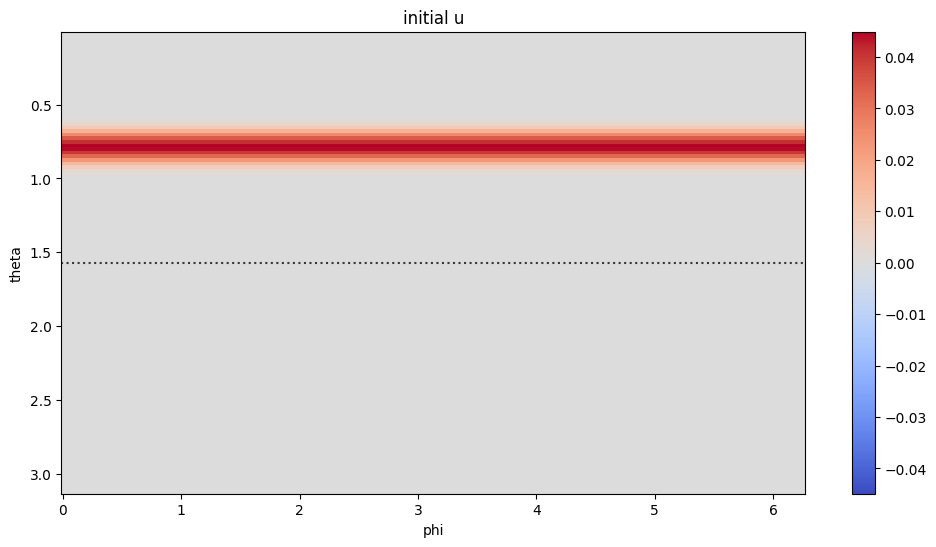

In [181]:
plt.figure(figsize=(12,6))
plt.title('initial u')
plt.pcolormesh(
    phi.squeeze(),
    theta.squeeze(),
    u['g'][0].T,
    cmap='coolwarm',
    norm=mcolors.CenteredNorm(vcenter=0),
    # levels=21
)
plt.colorbar()
plt.axhline(y=np.pi/2, ls=':', color='k', alpha=0.75)

plt.gca().invert_yaxis()
plt.xlabel('phi')
plt.ylabel('theta')
plt.gca().set_aspect('auto')

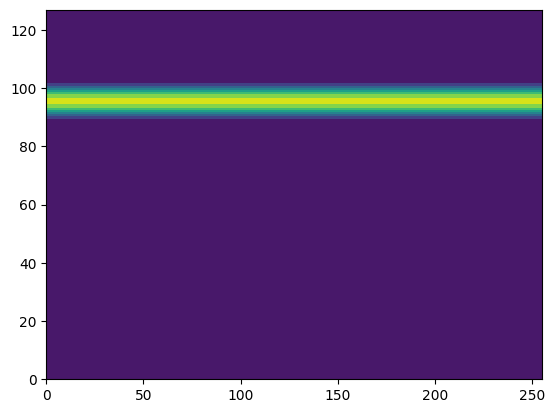

In [351]:
# # plt.pcolormesh(d3.grad(u)['g'][:,:, 150, 150], cmap='coolwarm', norm=mcolors.CenteredNorm())
# plt.pcolormesh(d3.grad(u)['g'][1,0].T, cmap='coolwarm', norm=mcolors.CenteredNorm())
# plt.colorbar()
# # plt.contourf((d3.Multiply(e_phi, e_phi)@d3.grad(u))['g'][0,1].T)

plt.contourf(u['g'][0].T)

In [350]:
u.copy()['g'].shape

(2, 256, 128)

In [392]:
# Fields
u = dist.Field(name='u', bases=basis)
v = dist.Field(name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Substitutions
# zcross = lambda A: d3.MulCosine(d3.skew(A))
zcross = lambda A: d3.skew(A)
dphi = lambda A: e_phi@d3.grad(A)
dtheta = lambda A: e_theta@d3.grad(A)

# Initial conditions: zonal jet
phi, theta = dist.local_grids(basis)
lat = np.pi / 2 - theta + 0*phi
umax = 80 * meter / second
lat0 = np.pi / 7
lat1 = np.pi / 2 - lat0
# lat0 = -np.pi / 8
# lat1 = np.pi / 2 - lat0
# lat1 = np.pi / 8
en = np.exp(-4 / (lat1 - lat0)**2)
jet = (lat0 <= lat) * (lat <= lat1)
u_jet = umax / en * np.exp(1 / (lat[jet] - lat0) / (lat[jet] - lat1))
u['g'][jet]  = u_jet

ncc_f = dist.Field(name='f', bases=basis)
ncc_f['g'] = 2*Omega*np.sin(np.pi/2 - theta)

# Solve BVP

In [129]:
# Initial conditions: balanced height
c = dist.Field(name='c')
problem = d3.LBVP([h, c], namespace=locals())
# problem.add_equation("g*lap(h) + c = - div(u@grad(u)) - div(2*Omega*zcross(u))")
problem.add_equation("g*lap(h) + c = - div(u@grad(u)) - div(ncc_f*zcross(u))")
problem.add_equation("ave(h) = 0")
solver = problem.build_solver()
solver.solve()

2024-03-11 10:53:42,665 subsystems 0/1 INFO :: Building subproblem matrices 1/127 (~1%) Elapsed: 0s, Remaining: 4s, Rate: 3.2e+01/s
2024-03-11 10:53:42,864 subsystems 0/1 INFO :: Building subproblem matrices 13/127 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 5.7e+01/s
2024-03-11 10:53:43,079 subsystems 0/1 INFO :: Building subproblem matrices 26/127 (~20%) Elapsed: 0s, Remaining: 2s, Rate: 5.8e+01/s
2024-03-11 10:53:43,295 subsystems 0/1 INFO :: Building subproblem matrices 39/127 (~31%) Elapsed: 1s, Remaining: 1s, Rate: 5.9e+01/s
2024-03-11 10:53:43,510 subsystems 0/1 INFO :: Building subproblem matrices 52/127 (~41%) Elapsed: 1s, Remaining: 1s, Rate: 5.9e+01/s
2024-03-11 10:53:43,726 subsystems 0/1 INFO :: Building subproblem matrices 65/127 (~51%) Elapsed: 1s, Remaining: 1s, Rate: 6.0e+01/s
2024-03-11 10:53:43,940 subsystems 0/1 INFO :: Building subproblem matrices 78/127 (~61%) Elapsed: 1s, Remaining: 1s, Rate: 6.0e+01/s
2024-03-11 10:53:44,134 subsystems 0/1 INFO :: Building subprobl

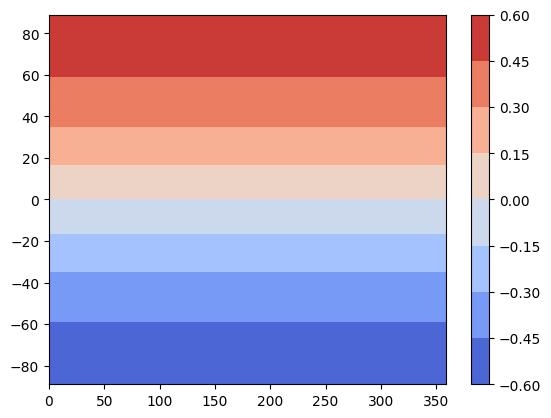

In [103]:
plt.contourf(
    180*phi.squeeze()/np.pi,
    180*(np.pi/2 - theta.squeeze())/np.pi,
    ncc_f['g'].T,
    cmap='coolwarm'
)
plt.colorbar()

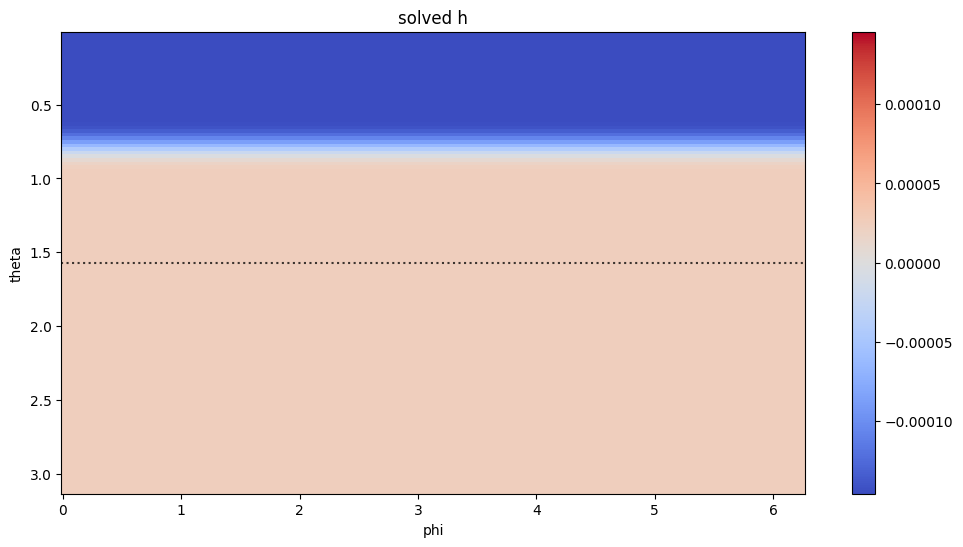

In [130]:
plt.figure(figsize=(12,6))
plt.title('solved h')
plt.pcolormesh(
    phi.squeeze(),
    theta.squeeze(),
    h['g'].T,
    cmap='coolwarm',
    norm=mcolors.CenteredNorm(vcenter=0),
    # levels=21
)
plt.colorbar()

plt.axhline(y=np.pi/2, ls=':', color='k', alpha=0.75)
plt.gca().invert_yaxis()
plt.xlabel('phi')
plt.ylabel('theta')
plt.gca().set_aspect('auto')

# Add a perturbation to the balanced height field

In [131]:
# Initial conditions: perturbation
lat2 = np.pi / 4
# lat2 = 0
hpert = 120 * meter
alpha = 1 / 3
beta = 1 / 15
perturbation = hpert * np.cos(lat) * np.exp(-(phi/alpha)**2) * np.exp(-((lat2-lat)/beta)**2)
h['g'] += perturbation

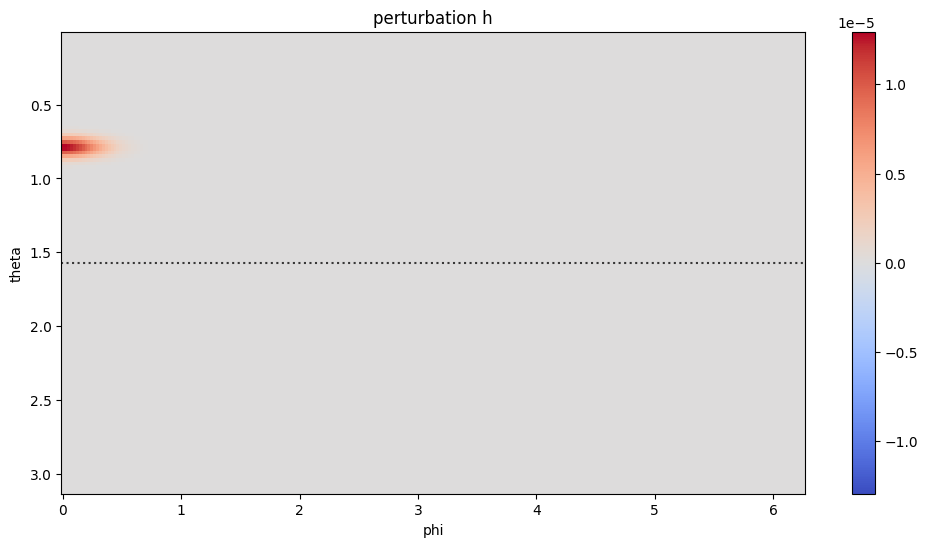

In [132]:
plt.figure(figsize=(12,6))
plt.title('perturbation h')
plt.pcolormesh(
    phi.squeeze(),
    theta.squeeze(),
    perturbation.T,
    cmap='coolwarm',
    norm=mcolors.CenteredNorm(vcenter=0),
    # levels=21
)

plt.axhline(y=np.pi/2, ls=':', color='k', alpha=0.75)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('phi')
plt.ylabel('theta')
plt.gca().set_aspect('auto')

# Solve IVP

In [133]:
# Problem
problem = d3.IVP([u, h], namespace=locals())
# problem.add_equation("dt(u) + nu*lap(lap(u)) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(u) + nu*lap(lap(u)) + g*grad(h) = - ncc_f*zcross(u) - u@grad(u)")
problem.add_equation("dt(h) + nu*lap(lap(h)) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler(
    'spherical_shallow_water_example/ncc_f_snapshots', 
    sim_dt=1*hour, 
    max_writes=10
)
snapshots.add_task(h, name='height')
snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')

# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            # logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            logger.info(f"Iteration {solver.iteration:>4.0f}, ({100*solver.iteration/total_iterations:.1f})%, time = {solver.sim_time:0.2f} hr")
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2024-03-11 10:54:37,412 subsystems 0/1 INFO :: Building subproblem matrices 1/127 (~1%) Elapsed: 0s, Remaining: 11s, Rate: 1.2e+01/s
2024-03-11 10:54:37,779 subsystems 0/1 INFO :: Building subproblem matrices 13/127 (~10%) Elapsed: 0s, Remaining: 4s, Rate: 2.9e+01/s
2024-03-11 10:54:38,175 subsystems 0/1 INFO :: Building subproblem matrices 26/127 (~20%) Elapsed: 1s, Remaining: 3s, Rate: 3.1e+01/s
2024-03-11 10:54:38,564 subsystems 0/1 INFO :: Building subproblem matrices 39/127 (~31%) Elapsed: 1s, Remaining: 3s, Rate: 3.2e+01/s
2024-03-11 10:54:38,888 subsystems 0/1 INFO :: Building subproblem matrices 52/127 (~41%) Elapsed: 2s, Remaining: 2s, Rate: 3.3e+01/s
2024-03-11 10:54:39,214 subsystems 0/1 INFO :: Building subproblem matrices 65/127 (~51%) Elapsed: 2s, Remaining: 2s, Rate: 3.4e+01/s
2024-03-11 10:54:39,547 subsystems 0/1 INFO :: Building subproblem matrices 78/127 (~61%) Elapsed: 2s, Remaining: 1s, Rate: 3.5e+01/s
2024-03-11 10:54:39,873 subsystems 0/1 INFO :: Building subprob

# Linearized problem

In [30]:
# Fields
U = dist.VectorField(coords, name='U', bases=basis)
H = dist.Field(name='H', bases=basis)

# Substitutions
# zcross = lambda A: d3.MulCosine(d3.skew(A))
zcross = lambda A: d3.skew(A)

dphi = lambda A: e_phi@d3.grad(A)
dtheta = lambda A: e_theta@d3.grad(A)

# Initial conditions: zonal jet
phi, theta = dist.local_grids(basis)
lat = np.pi / 2 - theta + 0*phi
umax = 80 * meter / second
lat0 = np.pi / 7
lat1 = np.pi / 2 - lat0
# lat0 = -np.pi / 8
# lat1 = np.pi / 2 - lat0
# lat1 = np.pi / 8
en = np.exp(-4 / (lat1 - lat0)**2)
jet = (lat0 <= lat) * (lat <= lat1)
u_jet = umax / en * np.exp(1 / (lat[jet] - lat0) / (lat[jet] - lat1))
U['g'][0][jet]  = u_jet

ncc_f = dist.Field(name='f', bases=basis)
ncc_f['g'] = 2*Omega*np.cos(theta)

# Initial conditions: balanced height
c = dist.Field(name='c')
problem = d3.LBVP([H, c], namespace=locals())
# problem.add_equation("g*lap(h) + c = - div(u@grad(u)) - div(2*Omega*zcross(u))")
problem.add_equation("g*lap(H) + c = - div(U@grad(U)) - div(ncc_f*zcross(U))")
problem.add_equation("ave(H) = 0")
solver = problem.build_solver()
solver.solve()

ncc_cot = dist.Field(name='cot_theta', bases=basis)
ncc_cot['g'] = 1/(R*np.tan(theta))

ncc_U = dist.Field(name='ncc_U', bases=basis)
ncc_U.change_scales(dealias)
# ncc_U['g'] = U.copy()['g'][0]
ncc_U['g'] = 0
ncc_U.change_scales(1)

ncc_H = dist.Field(name='ncc_H', bases=basis)
# ncc_H.change_scales(dealias)
# ncc_H['g'] = H.copy()['g']
ncc_H['g'] = 1e4
# ncc_H.change_scales(1)

2024-03-12 16:45:44,729 subsystems 0/1 INFO :: Building subproblem matrices 1/127 (~1%) Elapsed: 0s, Remaining: 4s, Rate: 3.5e+01/s
2024-03-12 16:45:44,931 subsystems 0/1 INFO :: Building subproblem matrices 13/127 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 5.7e+01/s
2024-03-12 16:45:45,149 subsystems 0/1 INFO :: Building subproblem matrices 26/127 (~20%) Elapsed: 0s, Remaining: 2s, Rate: 5.8e+01/s
2024-03-12 16:45:45,367 subsystems 0/1 INFO :: Building subproblem matrices 39/127 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 5.9e+01/s
2024-03-12 16:45:45,585 subsystems 0/1 INFO :: Building subproblem matrices 52/127 (~41%) Elapsed: 1s, Remaining: 1s, Rate: 5.9e+01/s
2024-03-12 16:45:45,805 subsystems 0/1 INFO :: Building subproblem matrices 65/127 (~51%) Elapsed: 1s, Remaining: 1s, Rate: 5.9e+01/s
2024-03-12 16:45:46,015 subsystems 0/1 INFO :: Building subproblem matrices 78/127 (~61%) Elapsed: 1s, Remaining: 1s, Rate: 5.9e+01/s
2024-03-12 16:45:46,195 subsystems 0/1 INFO :: Building subprobl

In [31]:
u = dist.Field(name='u', bases=basis)
v = dist.Field(name='v', bases=basis)
h = dist.Field(name='h', bases=basis)

# Initial conditions: perturbation
lat2 = np.pi / 4
# lat2 = 0
hpert = 120 * meter
alpha = 1 / 3
beta = 1 / 15
perturbation = hpert * np.cos(lat) * np.exp(-(phi/alpha)**2) * np.exp(-((lat2-lat)/beta)**2)
h['g'] = perturbation

In [33]:
# Problem
problem = d3.IVP([u, v, h], namespace=locals())
# problem.add_equation("dt(u) + nu*lap(lap(u)) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
# problem.add_equation("dt(h) + nu*lap(lap(h)) + H*div(u) = - div(h*u)")

problem.add_equation(
    "dt(u) + g*dphi(h) = -ncc_U*v*ncc_cot + ncc_f*v - ncc_U*dphi(u) + v*dtheta(ncc_U)"
)

problem.add_equation(
    "dt(v) - g*dtheta(h) = - ncc_f*ncc_U - ncc_f*u - ncc_U*dphi(v) - g*dtheta(ncc_H)"
)

problem.add_equation(
    "dt(h) =  - ncc_U*dphi(h) + v*dtheta(ncc_H) - ncc_H*dphi(u) + ncc_H*dtheta(v) - ncc_H*ncc_cot*v"
)

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler(
    'spherical_shallow_water_example/linearized_snapshots', 
    sim_dt=1*hour, 
    max_writes=10
)
snapshots.add_task(h, name='height')
snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')

# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            # logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            logger.info(f"Iteration {solver.iteration:>4.0f}, ({100*solver.iteration/total_iterations:.1f})%, time = {solver.sim_time:0.2f} hr")
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

NotImplementedError: Only last-axis NCCs implemented for this basis.

# Load output data

In [134]:
import xarray as xr
from glob import glob

output_data_files = glob(f"spherical_shallow_water_example/ncc_f_snapshots/ncc_f_snapshots_s*.h5")
height_list = []
vorticity_list = []
for data_file in output_data_files: 
    height_list.append(d3.load_tasks_to_xarray(data_file)['height'])
    vorticity_list.append(d3.load_tasks_to_xarray(data_file)['vorticity'])

output_height = xr.concat(height_list, dim='t')
output_vorticity = xr.concat(vorticity_list, dim='t')

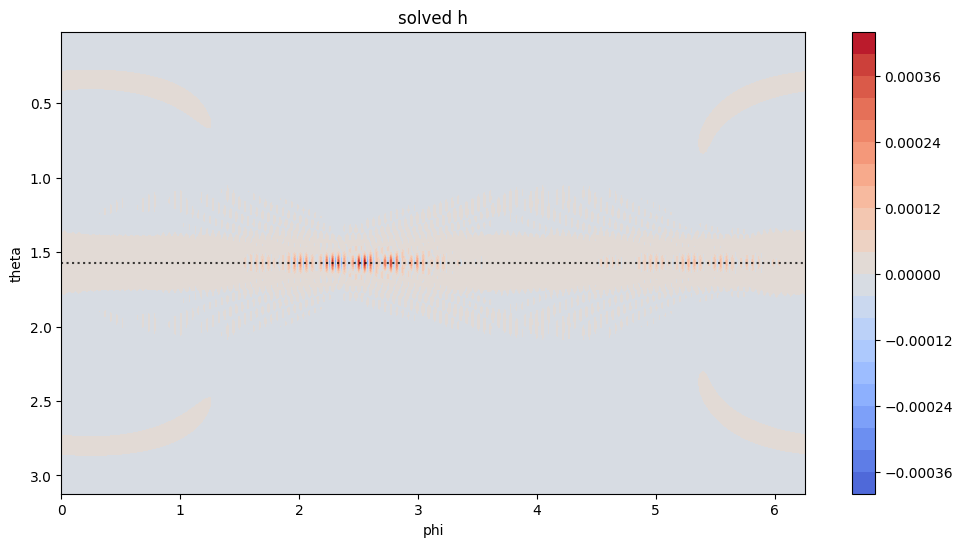

In [42]:
plt.figure(figsize=(12,6))
plt.title('solved h')
plt.contourf(
    phi.squeeze(),
    theta.squeeze(),
    output_height.isel(t=30).T,
    cmap='coolwarm',
    norm=mcolors.CenteredNorm(vcenter=0),
    levels=21
)
plt.colorbar()

# plt.contour(
#     h['g'].T,
#     colors='k'
# )

plt.axhline(y=np.pi/2, ls=':', color='black', alpha=0.75)

plt.gca().invert_yaxis()
plt.xlabel('phi')
plt.ylabel('theta')
plt.gca().set_aspect('auto')

  0%|                                                                       | 0/120 [00:00<?, ?it/s]

2024-03-05 10:28:57,564 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-03-05 10:28:57,568 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3200x1800 -pix_fmt rgba -framerate 3.3333333333333335 -i pipe: -vcodec h264 -pix_fmt yuv420p -y spherical_shallow_water_example/2d_height_field_animation.mp4


 99%|████████████████████████████████████████████████████████████▍| 119/120 [00:53<00:00,  2.18it/s]

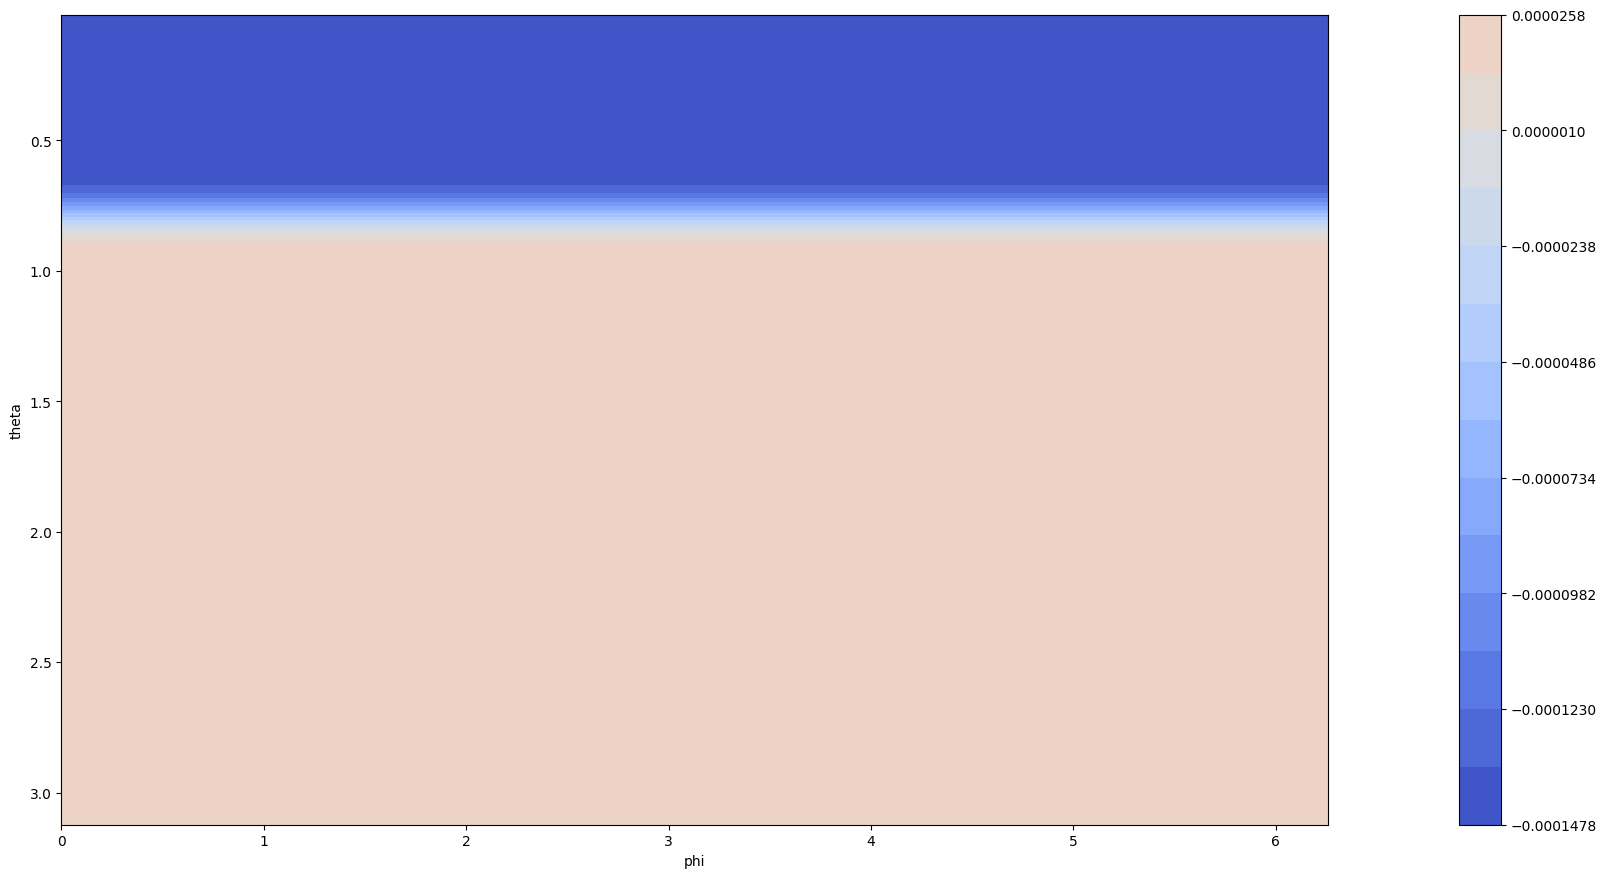

In [11]:
fig = plt.figure(figsize=(16,9))
gs = GridSpec(1, 2, width_ratios=[30,1], figure=fig)
gs.update(top=.95, bottom=0.05, left=0.05, right=.95)

ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

levels = np.linspace(np.min(output_height), np.max(output_height), 15)

from matplotlib.animation import FuncAnimation
from tqdm import tqdm

def update(t):
    ax.clear()
    cbar_ax.clear()
    
    CF = ax.contourf(
        phi.squeeze(),
        theta.squeeze(),
        output_height.isel(t=t).T,
        cmap='coolwarm',
        norm=mcolors.CenteredNorm(vcenter=0),
        levels=levels,
        # extend='both'
    )
    fig.colorbar(CF, cbar_ax)

# CS = ax.contour(
#     phi.squeeze(),
#     theta.squeeze(),
#     output_vorticity.isel(t=t),
#     colors='k'
# )

    ax.invert_yaxis()
    ax.set_xlabel('phi')
    ax.set_ylabel('theta')
    ax.set_aspect('auto')
# plt.show()

# Run the animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=tqdm(
        np.arange(0, 360, 3), 
        ncols=100, 
        position=0, 
        leave=True
    ), interval=300
)

anim.save(f"spherical_shallow_water_example/2d_height_field_animation.mp4", dpi=200)